In [224]:
import pandas as pd
from os.path import join
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import time,timedelta

sns.set()
sns.set_context('talk')
%matplotlib inline

In [139]:
timing_fpath = '../../data/raw/RA_records/timing.csv'
temps_dir = '../../data/raw/temp_sensors/main_experiment'

download_date = '20171001'
start_date = '2017-09-25'
end_date = '2017-09-29'

# Get timing data

In [238]:
# Load csv containing start and stop times for session
timing_df = pd.read_csv(timing_fpath,index_col = [0,1,2], parse_dates = True,
            usecols=['Date','Session in day','Treatment group','Time entering room','Time ending modules'])
timing_df = timing_df.loc[start_date:end_date,:]

timing_df['start_time'] = pd.to_datetime(
    timing_df.index.get_level_values(0).astype(str) + 'T' + timing_df['Time entering room'])
timing_df['end_time'] = pd.to_datetime(
    timing_df.index.get_level_values(0).astype(str) + 'T' + timing_df['Time ending modules'])

# Impute end time from other concurrent session if not recorded
min_end_times = timing_df.groupby(level=[0,1])['end_time'].min()
max_start_times = timing_df.groupby(level=[0,1])['start_time'].max()
imputed_vals = pd.DataFrame({'min_end_time':min_end_times,
               'max_start_time':max_start_times},index = min_end_times.index)

imputed_vals = imputed_vals.append(imputed_vals)
imputed_vals['Treatment group'] = [0] * int(imputed_vals.shape[0] / 2) + [1] * int(imputed_vals.shape[0] / 2)
imputed_vals = imputed_vals.set_index('Treatment group',append=True)

timing_df = timing_df.join(imputed_vals)
timing_df.loc[:,'start_time'] = timing_df.loc[:,'start_time'].where(
    cond=timing_df.loc[:,'start_time'].notnull(), other=timing_df['max_start_time'])
timing_df.loc[:,'end_time'] = timing_df.loc[:,'end_time'].where(
    cond=timing_df.loc[:,'end_time'].notnull(), other=timing_df['min_end_time'])

timing_df = timing_df[['start_time','end_time']]

## Correct for not using 24 hour clock
for i in ['start_time','end_time']:
    bad_times_bool = (timing_df[i].dt.time < time(10)) & (timing_df.index.get_level_values(1) == 2)
    bad_times = timing_df.loc[bad_times_bool,i]
    new_times = bad_times + timedelta(hours=12)
    timing_df[i] = timing_df[i].where(bad_times_bool==False,other=new_times)

# Get temp data

In [345]:
def make_plots_and_means(dfs,timing_df,site_str,out_name,means=None):
    if means==None:
        means = {}
        
    means[site_str] = {}
    experiment_dates = timing_df.index.get_level_values(0).unique()
    n_ex = len(experiment_dates)

    pretty_metrics = ['Temperature','RH']
    marker_colors = ['b','g']
    
    for mi,metric in enumerate(['temp','rh']):
        
        means[site_str][metric] = {}
        means[site_str][metric]['control'] = {}
        means[site_str][metric]['treatment'] = {}
        fig,ax = plt.subplots(n_ex,2,figsize = (12,n_ex*6))
        if len(experiment_dates) == 1: ax = np.array([ax])
        
        for ei,e in enumerate(experiment_dates):
            for gi,g in enumerate(['control','treatment']):
                
                this_ax = ax[ei,gi]
                first_ax = ax[0,0]
                second_ax = ax[0,1]
                last_ax = ax[n_ex-1,1]
                    
                for sesh in [1,2]:
                    
                    # skip if session was cancelled
                    this_group = (e,sesh,gi)
                    if this_group not in timing_df.index:
                        continue
                    times = timing_df.loc[this_group]

                    # skip if that session didn't run for some reason
                    data = dfs[g]['partition'].loc[times['start_time']:times['end_time']]
                    data = data.reset_index(drop=True)
                    metric_df = data.iloc[:,mi]
                    
                    if ei == 0 and sesh == 1:
                        means[site_str][metric][g]['partition'] = [metric_df.mean()]
                    else:
                        means[site_str][metric][g]['partition'].append(metric_df.mean())
                    metric_df.name = '{} Behind Partition, Session {}'.format(pretty_metrics[mi],sesh)
                    metric_df.plot(ax=this_ax,color=marker_colors[sesh-1])
                    this_ax

                    if metric == 'temp':
                        metric_df = dfs[g]['RA'].loc[times['start_time']:times['end_time']]
                        metric_df = metric_df.reset_index(drop=True)
                        if ei == 0 and sesh == 1:
                            means[site_str][metric][g]['RA'] = [metric_df.mean()]
                        else:
                            means[site_str][metric][g]['RA'].append(metric_df.mean())
                            
                        metric_df.name = '{} Under RA Desk, Session {}'.format(pretty_metrics[mi],sesh)
                        metric_df.plot(ax=this_ax,style=':',color=marker_colors[sesh-1])
                        
                this_ax.set_title('{}, {}'.format(e.date(), g.title()))
        
        last_ax.legend(loc='lower right')

        fig.suptitle('{} {} Measurements'.format(
            site_str.title(),pretty_metrics[mi]),fontsize=18)
        fig.tight_layout()
        fig.subplots_adjust(top=.95)
        fig.savefig('../../results/figures/main_experiment/{}_{}.png'.format(out_name,metric))

    return means


In [320]:
## Load DFs
dfs = {'treatment':{},
      'control':{}}
for gi,g in enumerate(['control','treatment']):
    dfs[g]['partition'] = pd.read_excel(join(temps_dir,'{}_{}_partition.xls'.format(download_date,g)),
                      sheetname='Records',parse_dates=True,index_col=0)
    dfs[g]['RA'] = pd.read_excel(join(temps_dir,'{}_{}_RA.xls'.format(download_date,g)),
                      sheetname='Data Table',parse_dates=True,index_col=1,header=21).iloc[:,1]

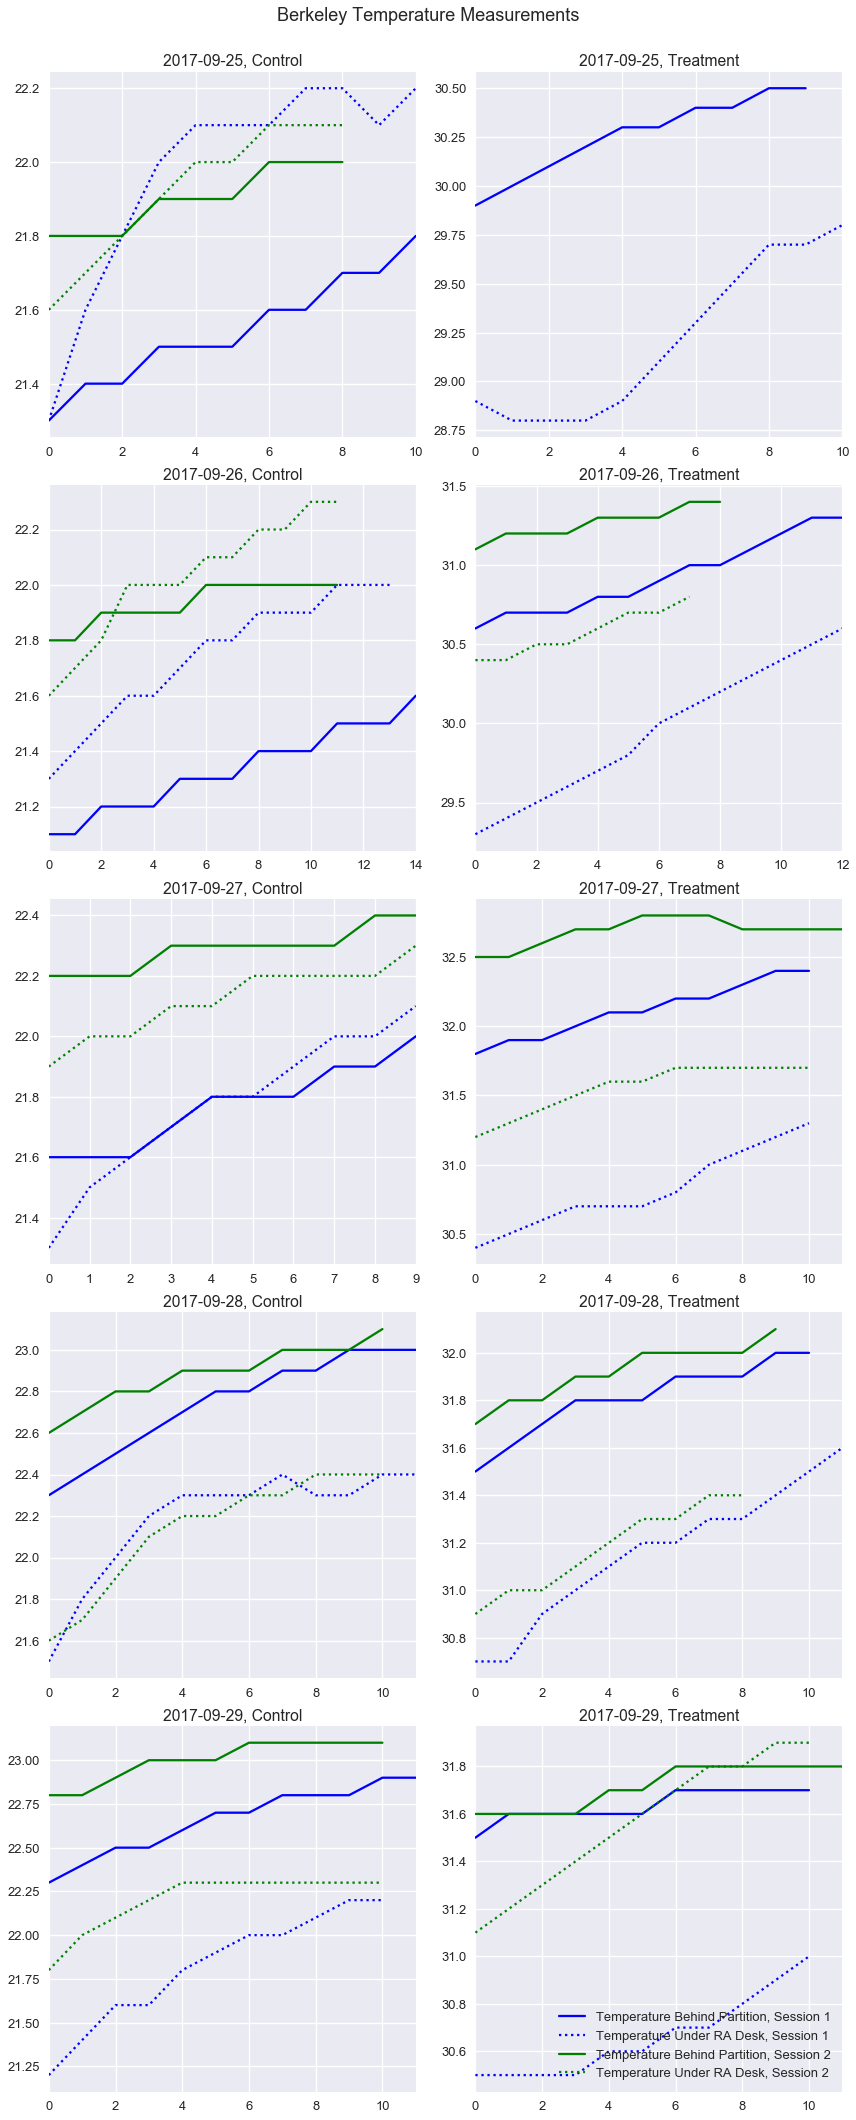

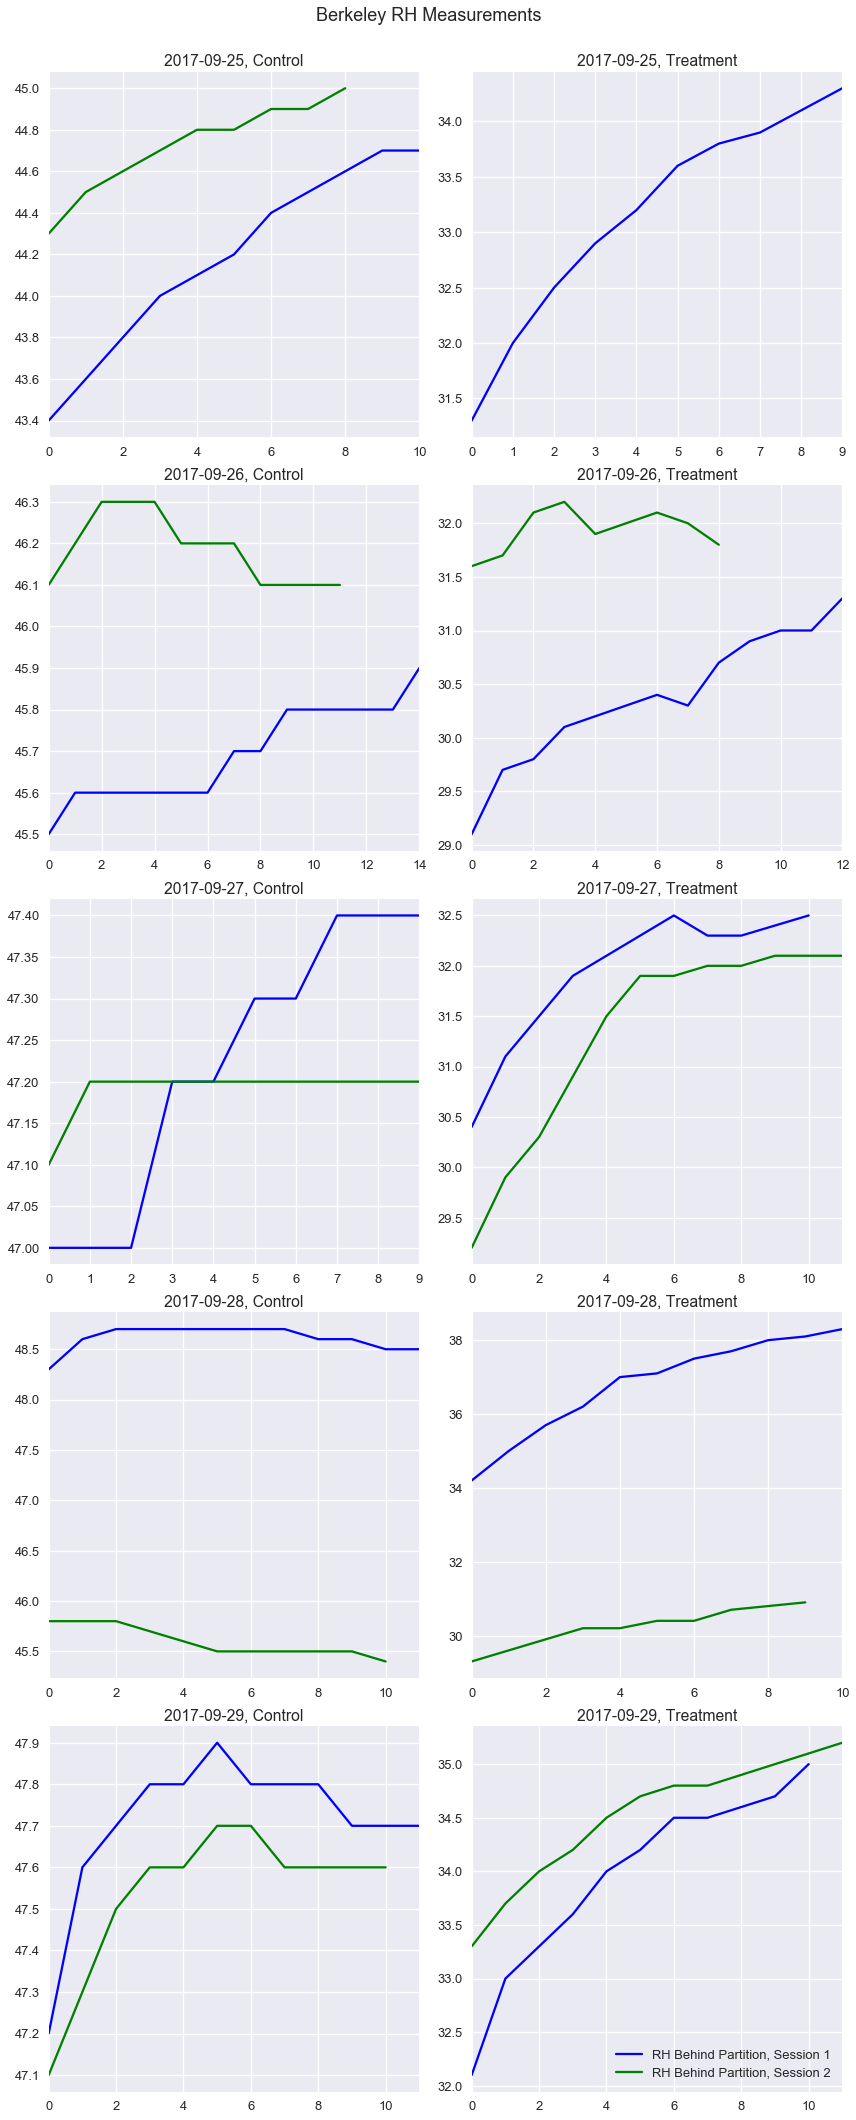

In [346]:
means = {}
means = make_plots_and_means(dfs,timing_df,'berkeley','week1_temps')

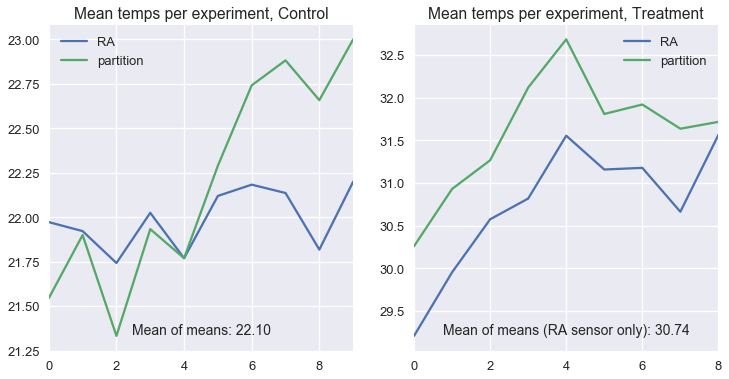

In [349]:
fig,ax = plt.subplots(1,2,figsize = (12,6))

for ix,i in enumerate(['control','treatment']):
    mean_temps = pd.DataFrame(means['berkeley']['temp'][i])
    mean_temps.plot(ax=ax[ix])
    ax[ix].set_title('Mean temps per experiment, {}'.format(i.title()))
    
control_means = means['berkeley']['temp']['control']
mean_of_means_control = np.array(control_means['RA'] + control_means['partition']).sum() / (2*len(control_means['RA']))

## do mean of means for treatment using only partition sensor, since clear bias
tx_means = means['berkeley']['temp']['treatment']
mean_of_means_tx = np.array(tx_means['RA']).sum() / len(tx_means['RA'])

ax[0].text(x = .5,y=.05,s='Mean of means: {:.2f}'.format(mean_of_means_control),
           fontsize=14,transform = ax[0].transAxes,horizontalalignment='center')
ax[1].text(x = .5,y=.05,s='Mean of means (RA sensor only): {:.2f}'.format(mean_of_means_tx),
           fontsize=14,transform = ax[1].transAxes,horizontalalignment='center')

fig.savefig('../../results/figures/main_experiment/week1_mean_temps.png')